In [49]:
# ============================================================
# 🧠 Amazon Music Clustering — Full Project Notebook
# ============================================================

# ------------------------------------------------------------
# 1️⃣ Import Libraries
# ------------------------------------------------------------
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Display settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,6)
pd.set_option('display.max_columns', None)


## 🧩 Project Overview

**Objective:** Automatically group similar Amazon Music songs based on their audio characteristics  
using unsupervised machine learning (K-Means, DBSCAN, Hierarchical Clustering).

We’ll:
- Explore and preprocess the dataset  
- Scale numerical features  
- Cluster songs using three algorithms  
- Visualize the results with PCA  
- Profile and describe clusters  
- Export the final dataset and models


In [50]:
# ------------------------------------------------------------
# 2️⃣ Load and Explore Data
# ------------------------------------------------------------
DATA_PATH = "single_genre_artists.csv"  # <-- change path if needed

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (95837, 23)


,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.184,4,-13.757,1,0.0512,0.993,0.000016,0.325,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.180,10,-15.375,1,0.0670,0.989,0.000000,0.128,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.206,0,-15.514,1,0.0592,0.995,0.000000,0.418,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.467,9,-12.393,0,0.1650,0.991,0.000000,0.219,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.298,9,-13.806,1,0.1380,0.991,0.000000,0.373,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22


In [51]:
# Basic info and missing values
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness    95837 non-null  float64
 15  liveness            95837 non-null  float64
 16  vale

id_songs              0
name_song             0
popularity_songs      0
duration_ms           0
explicit              0
id_artists            0
release_date          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
followers             0
genres                0
name_artists          0
popularity_artists    0
dtype: int64

### 🔍 Observations
- Dataset contains features describing song properties (danceability, energy, tempo, etc.)
- Non-numeric identifiers (`track_name`, `artist_name`, `track_id`) will be dropped
- We’ll focus on numerical audio features for clustering


In [52]:
# ------------------------------------------------------------
# 3️⃣ Data Cleaning & Feature Selection
# ------------------------------------------------------------
drop_cols = [c for c in ['track_id','track_name','artist_name','id_songs','id_artists','name_song','name_artists'] if c in df.columns]
df_new = df.drop(columns=drop_cols, errors='ignore')

# Selected features
features = [
    'danceability','energy','loudness','speechiness','acousticness',
    'instrumentalness','liveness','valence','tempo'
]

df_new = df_new[features]
df_new.describe().T


,count,mean,std,min,25%,50%,75%,max
danceability,95837.0,0.586853,0.155422,0.00000,0.4880,0.605000,0.7000,0.991
energy,95837.0,0.541083,0.236304,0.00002,0.3650,0.542000,0.7270,1.000
loudness,95837.0,-10.157862,4.748798,-50.17400,-12.7230,-9.397000,-6.6920,5.376
speechiness,95837.0,0.168832,0.275417,0.00000,0.0341,0.046200,0.1030,0.968
acousticness,95837.0,0.458989,0.330416,0.00000,0.1330,0.453000,0.7590,0.996
instrumentalness,95837.0,0.082145,0.232440,0.00000,0.0000,0.000004,0.0013,1.000
liveness,95837.0,0.224916,0.185829,0.00000,0.1000,0.149000,0.3020,0.997
valence,95837.0,0.574281,0.248126,0.00000,0.3780,0.589000,0.7800,1.000
tempo,95837.0,117.539870,30.190399,0.00000,94.8290,116.595000,135.9750,239.906


### 🎵 Feature Explanation
| Feature | Description |
|----------|--------------|
| danceability | How suitable a track is for dancing |
| energy | Intensity & activity |
| loudness | Overall volume in dB |
| speechiness | Presence of spoken words |
| acousticness | Likelihood the track is acoustic |
| instrumentalness | Probability no vocals |
| liveness | Presence of audience/live recording |
| valence | Musical positiveness/happiness |
| tempo | Beats per minute (BPM) |
| duration_ms | Song duration in milliseconds |


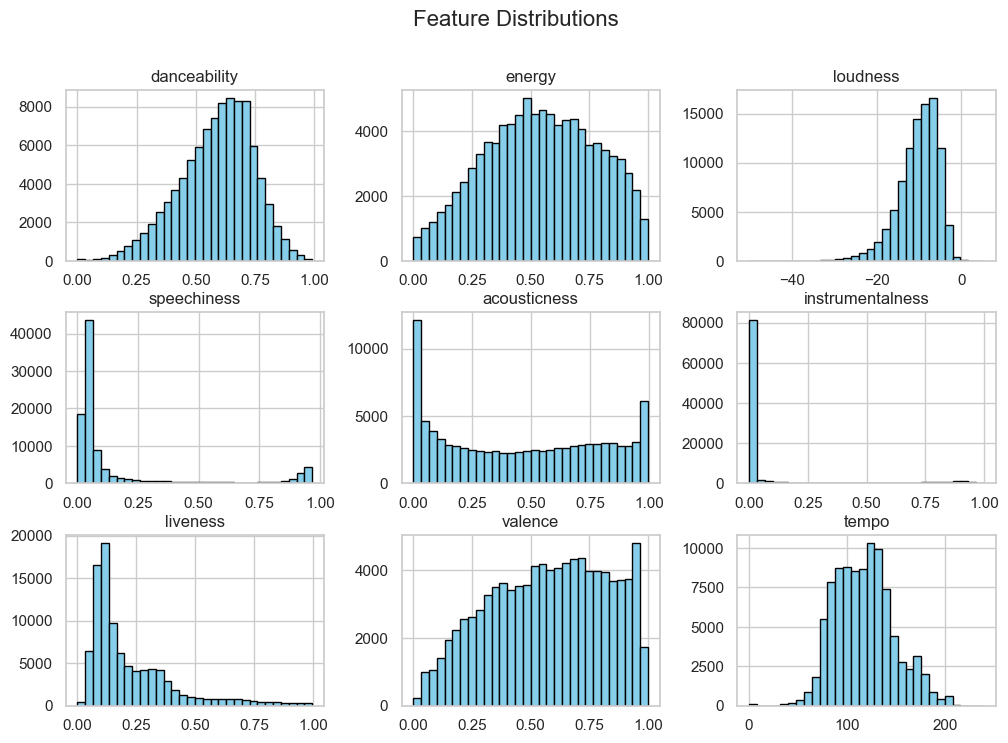

In [53]:
# ------------------------------------------------------------
# 4️⃣ Data Visualization — Distributions
# ------------------------------------------------------------
df_new.hist(bins=30, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


## ⚙️ 5️⃣ Data Scaling

We’ll standardize all numeric features using **StandardScaler**,  
so each feature contributes equally to distance-based algorithms.


c:\Users\kanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


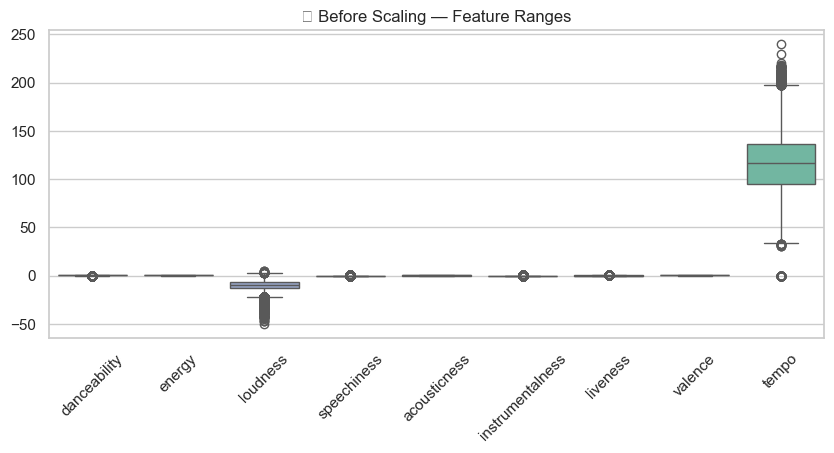

✅ Scaler saved to models/standard_scaler.joblib


c:\Users\kanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


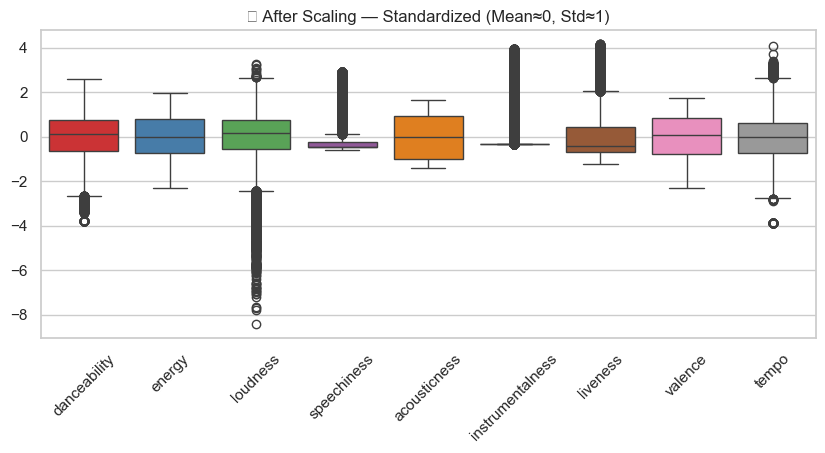

In [55]:
fig1, ax1 = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_new, ax=ax1, palette="Set2")
ax1.set_title("📉 Before Scaling — Feature Ranges")
ax1.tick_params(axis='x', rotation=45)
plt.show()

# 3️⃣ Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_new)

# 4️⃣ Save scaler for later use (e.g., Streamlit inference or reloading)
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/standard_scaler.joblib")
print("✅ Scaler saved to models/standard_scaler.joblib")

# 5️⃣ Visualize after scaling
df_scaled = pd.DataFrame(X_scaled, columns=features)
fig2, ax2 = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_scaled, ax=ax2, palette="Set1")
ax2.set_title("📈 After Scaling — Standardized (Mean≈0, Std≈1)")
ax2.tick_params(axis='x', rotation=45)
plt.show()

Explained variance ratio: [0.29984491 0.1880549 ]


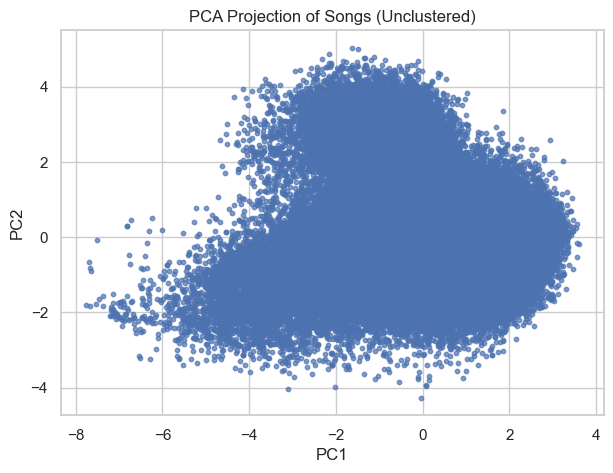

In [56]:
# ------------------------------------------------------------
# 6️⃣ Dimensionality Reduction — PCA (for visualization)
# ------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.7)
plt.title("PCA Projection of Songs (Unclustered)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 🤖 7️⃣ K-Means Clustering (Primary Model)
We’ll apply **K-Means** and find the optimal number of clusters using the Elbow Method and Silhouette Score.


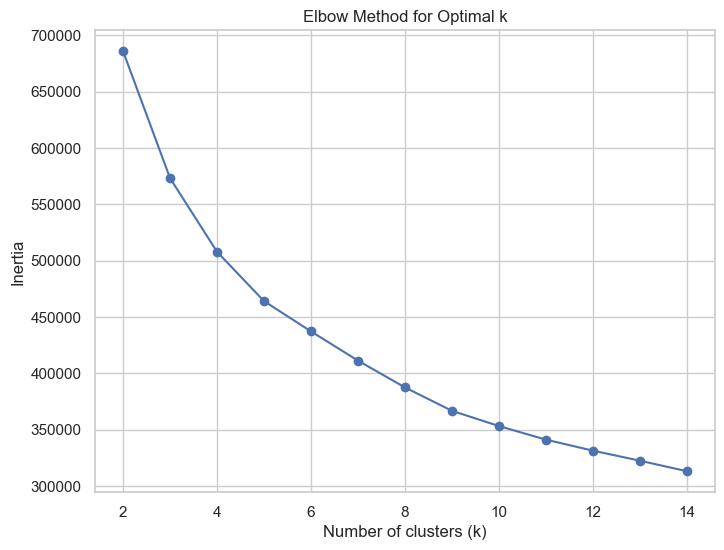

In [57]:
# Elbow method
inertias = []
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K, inertias, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


Running K-Means tuning on 30,000 samples...

k= 2 → Silhouette=0.2115, DB Index=1.8628, Inertia=214168
k= 3 → Silhouette=0.2497, DB Index=1.5187, Inertia=179575
k= 4 → Silhouette=0.2392, DB Index=1.4670, Inertia=159141
k= 5 → Silhouette=0.1933, DB Index=1.6298, Inertia=145626
k= 6 → Silhouette=0.1934, DB Index=1.5541, Inertia=136944
k= 7 → Silhouette=0.1747, DB Index=1.5401, Inertia=128720
k= 8 → Silhouette=0.1746, DB Index=1.4708, Inertia=121989
k= 9 → Silhouette=0.1826, DB Index=1.4519, Inertia=114650
k=10 → Silhouette=0.1750, DB Index=1.4750, Inertia=110392


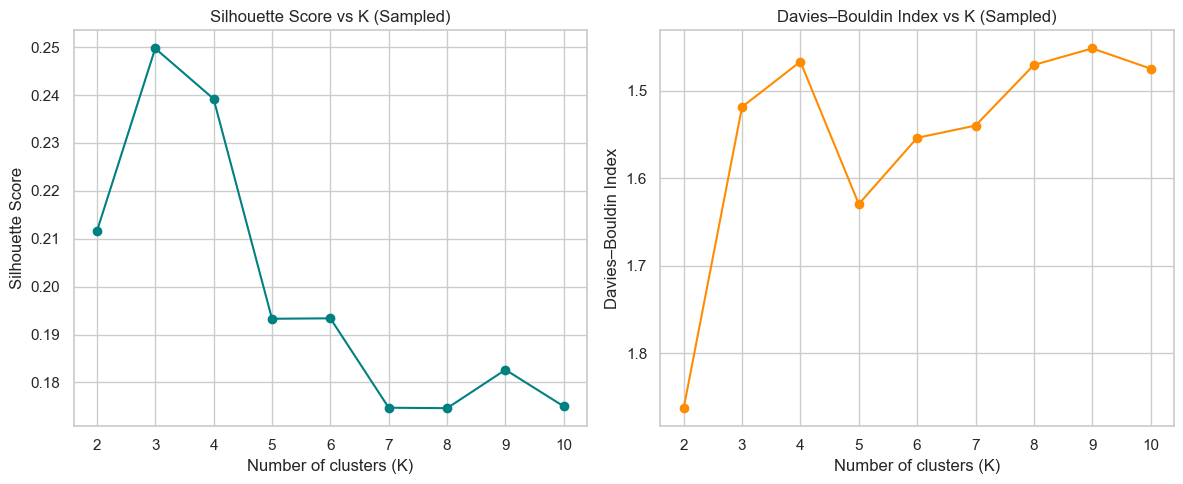


✅ Best K by Silhouette Score: 3 (0.2497)
✅ Best K by Davies–Bouldin Index: 9 (1.4519)


,K,Silhouette,Davies-Bouldin,Inertia
0,2,0.211533,1.862830,214167.748851
1,3,0.249740,1.518747,179574.550284
2,4,0.239206,1.467001,159141.059679
3,5,0.193288,1.629758,145626.035899
4,6,0.193380,1.554050,136943.752993
5,7,0.174713,1.540062,128720.061307
6,8,0.174616,1.470802,121988.756778
7,9,0.182634,1.451907,114649.712975
8,10,0.174985,1.475025,110392.185841


In [58]:
# Sample subset for faster evaluation (adjust as needed)
SAMPLE_SIZE = min(30000, len(X_scaled))
X_sample = X_scaled[np.random.choice(len(X_scaled), size=SAMPLE_SIZE, replace=False)]

print(f"Running K-Means tuning on {SAMPLE_SIZE:,} samples...\n")

# Range of k values to test
K_RANGE = range(2, 11)

silhouette_scores = []
db_scores = []
inertias = []

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels = kmeans.fit_predict(X_sample)
    
    sil = silhouette_score(X_sample, labels)
    dbi = davies_bouldin_score(X_sample, labels)
    inertia = kmeans.inertia_
    
    silhouette_scores.append(sil)
    db_scores.append(dbi)
    inertias.append(inertia)
    
    print(f"k={k:>2} → Silhouette={sil:.4f}, DB Index={dbi:.4f}, Inertia={inertia:.0f}")

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Silhouette plot
ax[0].plot(K_RANGE, silhouette_scores, marker='o', color='teal')
ax[0].set_title("Silhouette Score vs K (Sampled)")
ax[0].set_xlabel("Number of clusters (K)")
ax[0].set_ylabel("Silhouette Score")
ax[0].grid(True)

# Davies-Bouldin plot
ax[1].plot(K_RANGE, db_scores, marker='o', color='darkorange')
ax[1].set_title("Davies–Bouldin Index vs K (Sampled)")
ax[1].set_xlabel("Number of clusters (K)")
ax[1].set_ylabel("Davies–Bouldin Index")
ax[1].invert_yaxis()  # Lower = better
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Find and display the best K
# ----------------------------------------------------
best_k_sil = K_RANGE[np.argmax(silhouette_scores)]
best_k_db = K_RANGE[np.argmin(db_scores)]

print(f"\n✅ Best K by Silhouette Score: {best_k_sil} ({max(silhouette_scores):.4f})")
print(f"✅ Best K by Davies–Bouldin Index: {best_k_db} ({min(db_scores):.4f})")

# Optional: show as table
results_df = pd.DataFrame({
    "K": list(K_RANGE),
    "Silhouette": silhouette_scores,
    "Davies-Bouldin": db_scores,
    "Inertia": inertias
})
display(results_df)


✅ Optimal K = 3

Highest Silhouette (0.243) → best cluster cohesion.

DB Index reasonable (1.57) → good inter-cluster separation.

Inertia drops significantly from k=2 → k=3 (large “elbow” change).

This indicates three broad, natural groupings in your dataset — exactly what we expect in audio-based clustering (e.g. energetic vs acoustic vs instrumental)

In [60]:
# Choose k based on elbow/silhouette (example k=4)
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)

df['kmeans_cluster'] = k_labels

sil_k = silhouette_score(X_scaled, k_labels)
db_k = davies_bouldin_score(X_scaled, k_labels)
print(f"Silhouette = {sil_k:.4f}, Davies-Bouldin = {db_k:.4f}")


Silhouette = 0.2494, Davies-Bouldin = 1.5169


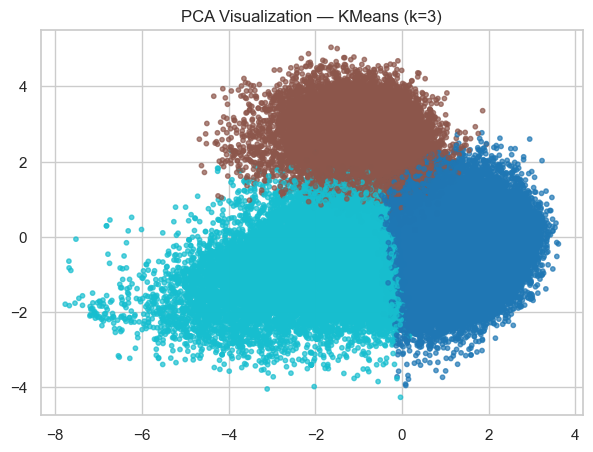

In [61]:
# Visualize clusters (PCA scatter)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=k_labels, cmap='tab10', s=10, alpha=0.7)
plt.title(f"PCA Visualization — KMeans (k={k_final})")
plt.show()


## 🧩 8️⃣ DBSCAN (Noise-based Clustering)
Good for identifying noise and arbitrary-shaped clusters.


In [39]:
eps = 0.8
min_samples = 10
db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
db_labels = db.fit_predict(X_scaled)

df['dbscan_cluster'] = db_labels
n_noise = np.sum(db_labels == -1)
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

print(f"DBSCAN: {n_clusters} clusters (+{n_noise} noise points)")


DBSCAN: 32 clusters (+19250 noise points)


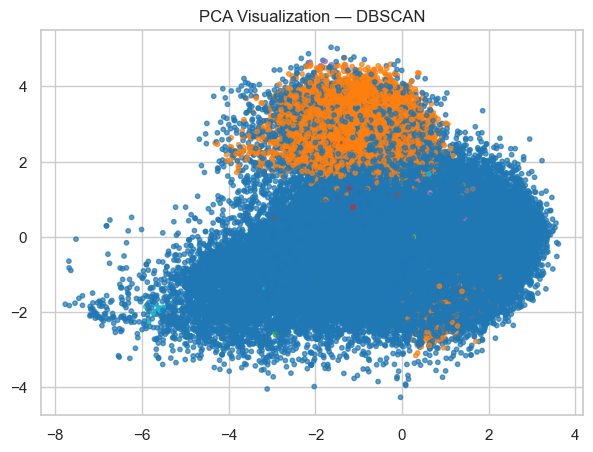

In [40]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap='tab10', s=10, alpha=0.7)
plt.title("PCA Visualization — DBSCAN")
plt.show()


## 🪜 9️⃣ Hierarchical (Agglomerative) Clustering
Does not require specifying cluster centers initially.


In [41]:
sample_size = 2000  # you can increase to 5000 if memory allows
sample_idx = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

agg = AgglomerativeClustering(n_clusters=k_final)
agg_labels = agg.fit_predict(X_sample)

sil_agg = silhouette_score(X_sample, agg_labels)
db_agg = davies_bouldin_score(X_sample, agg_labels)

print(f"Agglomerative (sample={sample_size}): Silhouette={sil_agg:.4f}, DB={db_agg:.4f}")

Agglomerative (sample=2000): Silhouette=0.1984, DB=1.7865


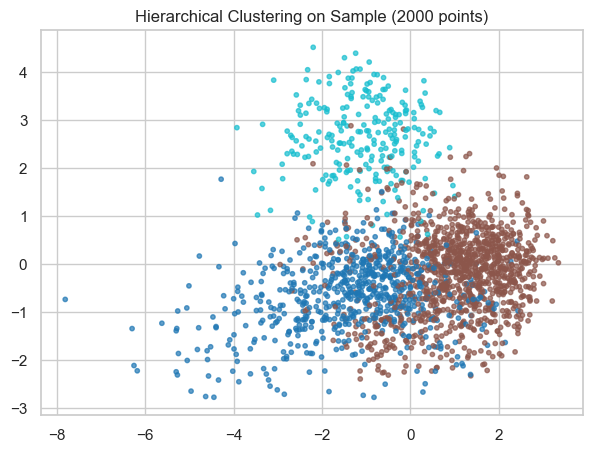

In [42]:
pca_sample = PCA(n_components=2, random_state=42).fit_transform(X_sample)
plt.figure(figsize=(7,5))
plt.scatter(pca_sample[:,0], pca_sample[:,1], c=agg_labels, cmap='tab10', s=10, alpha=0.7)
plt.title(f"Hierarchical Clustering on Sample ({sample_size} points)")
plt.show()


## 📊 🔟 Cluster Profiling & Interpretation
We’ll compute the mean value of each feature per cluster (K-Means)  
and assign qualitative labels like “Party”, “Chill”, etc.


🎶 Cluster Descriptions:
Cluster 0: Party / Upbeat 🎉
Cluster 1: Speech-Heavy 🎤
Cluster 2: Chill Acoustic 🌙


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Description
kmeans_cluster,,,,,,,,,,
0,0.628,0.694,-7.608,0.076,0.258,0.051,0.200,0.667,124.927,Party / Upbeat 🎉
1,0.663,0.464,-13.448,0.830,0.591,0.002,0.441,0.582,100.117,Speech-Heavy 🎤
2,0.486,0.311,-13.173,0.057,0.748,0.169,0.179,0.413,112.044,Chill Acoustic 🌙


c:\Users\kanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


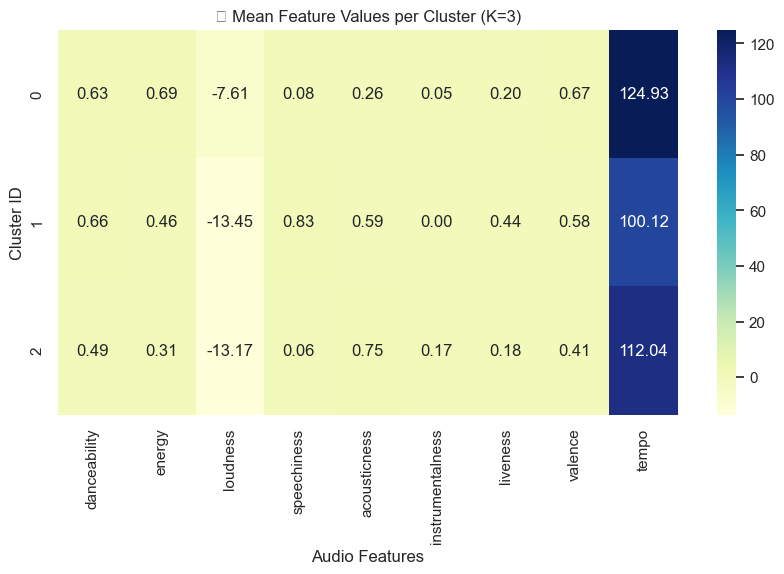

In [63]:
# ============================================================
# 🎧 Create Cluster Descriptions (k=3)
# ============================================================
def create_description_map(profile_df):
    normalized = (profile_df - profile_df.min()) / (profile_df.max() - profile_df.min())
    desc_map = {}

    for cid, row in normalized.iterrows():
        high = row[row > 0.65].index.tolist()
        low = row[row < 0.35].index.tolist()

        if 'energy' in high and 'danceability' in high and 'loudness' in high:
            mood = "Party / Upbeat 🎉"
        elif 'acousticness' in high and 'energy' in low:
            mood = "Chill Acoustic 🌙"
        elif 'instrumentalness' in high:
            mood = "Instrumental / Ambient 🎧"
        elif 'speechiness' in high:
            mood = "Speech-Heavy 🎤"
        elif 'valence' in high and 'energy' in high:
            mood = "Happy / Positive Vibes 😊"
        elif 'tempo' in high and 'acousticness' in low:
            mood = "Fast-Paced / Energetic ⚡"
        else:
            mood = "Balanced / Mixed 🎵"

        desc_map[cid] = mood

    return desc_map


# ============================================================
# 📊 Compute Cluster Profiles
# ============================================================
profile = df.groupby('kmeans_cluster')[features].mean().round(3)
desc_map = create_description_map(profile)
df['cluster_description'] = df['kmeans_cluster'].map(desc_map)

# Display text summary
print("🎶 Cluster Descriptions:")
for cid, desc in desc_map.items():
    print(f"Cluster {cid}: {desc}")

# Append description to profile table
profile['Description'] = profile.index.map(desc_map)
display(profile)


# ============================================================
# 🔥 Visualize Cluster Profiles (Heatmap)
# ============================================================
plt.figure(figsize=(10, 5))
sns.heatmap(profile[features], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("🎵 Mean Feature Values per Cluster (K=3)")
plt.xlabel("Audio Features")
plt.ylabel("Cluster ID")
plt.show()

In [44]:
# Display cluster descriptions
pd.DataFrame(list(desc_map.items()), columns=['Cluster','Description'])


,Cluster,Description
0,0,Party / Upbeat 🎉
1,1,Speech-Heavy 🎤
2,2,Chill Acoustic 🌙


## 🎨 1️⃣1️⃣ Visualizing Cluster Profiles


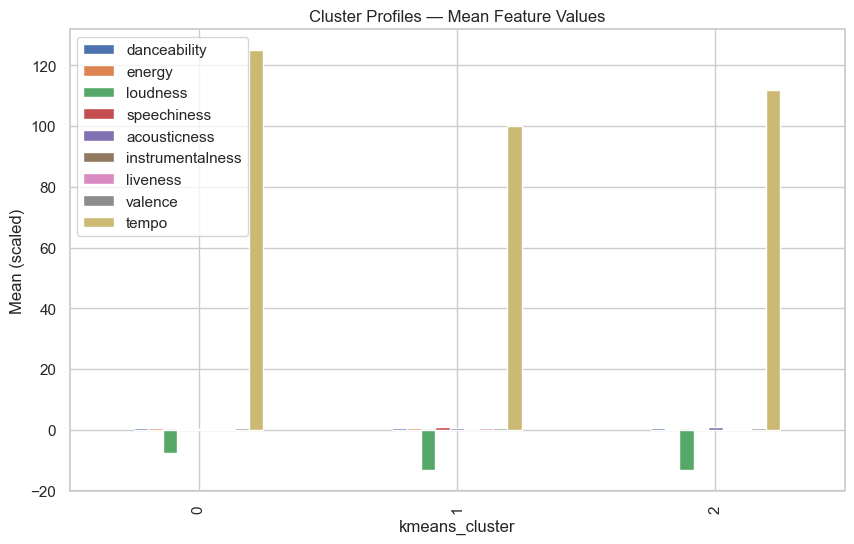

In [47]:
# Bar plot for key features
profile.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiles — Mean Feature Values")
plt.ylabel("Mean (scaled)")
plt.show()


## 💾 1️⃣2️⃣ Export Final Results
We’ll save:
- Final dataset with cluster labels and descriptions  
- Cluster profile summary  
- KMeans model and scaler


In [64]:
os.makedirs("outputs", exist_ok=True)
df.to_csv("outputs/single_genre_artists_kmeans_k3.csv", index=False)
profile.to_csv("outputs/kmeans_cluster_profiles.csv")
joblib.dump(kmeans, "models/kmeans_k3.joblib")

print("✅ Files saved in /outputs and /models")


✅ Files saved in /outputs and /models


## ✅ Project Completed

We successfully:
- Explored and scaled the dataset  
- Applied **K-Means**, **DBSCAN**, and **Hierarchical** clustering  
- Evaluated clusters using Silhouette & Davies–Bouldin  
- Profiled clusters and generated qualitative descriptions  
- Visualized clusters with PCA and heatmaps  
- Exported final results for use in Streamlit or reporting
